# Imports

In [32]:
# Tobi

from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from xgboost import XGBClassifier

In [18]:
# Simon

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

# Data Analysis Tobi

In [19]:
mushrooms_train = pd.read_csv('data/train.csv')
mushrooms_test = pd.read_csv('data/test.csv')

## Value Counts
* Balanced classes
* All data categorical
* Some categories have only few members

In [20]:
for column in mushrooms_train.columns:
    print(column, '\n', mushrooms_train[column].value_counts().sort_values(ascending=False), '\n')

cap.shape 
 x    2935
f    2534
k     652
b     349
s      28
c       1
Name: cap.shape, dtype: int64 

cap.color 
 n    1823
g    1487
e    1197
y     848
w     823
b     143
p     117
c      34
u      14
r      13
Name: cap.color, dtype: int64 

bruises 
 False    3764
True     2735
Name: bruises, dtype: int64 

stalk.color.above.ring 
 w    3537
p    1536
g     452
n     358
b     346
o     156
e      78
c      29
y       7
Name: stalk.color.above.ring, dtype: int64 

stalk.color.below.ring 
 w    3481
p    1494
g     467
n     421
b     352
o     156
e      80
c      29
y      19
Name: stalk.color.below.ring, dtype: int64 

population 
 v    3219
y    1392
s     993
n     320
a     302
c     273
Name: population, dtype: int64 

Id 
 6573    1
1895    1
5789    1
6187    1
2508    1
       ..
6206    1
4658    1
5000    1
6381    1
373     1
Name: Id, Length: 6499, dtype: int64 

poisonous 
 0    3342
1    3157
Name: poisonous, dtype: int64 



## Missing Values
* No missing values

In [21]:
for column in mushrooms_test.columns:
    print(column, '\n', mushrooms_test[column].isna().sum(), '\n')

Id 
 0 

cap.shape 
 0 

cap.color 
 0 

stalk.color.above.ring 
 0 

stalk.color.below.ring 
 0 

bruises 
 0 

population 
 0 



In [22]:
# Split in features and target
X = mushrooms_train.drop(['poisonous'], axis=1)
y = mushrooms_train['poisonous']

# Preprocessor pipe

In [23]:
preprocessor = Pipeline(steps= [
    ('transformer', OneHotEncoder(drop= 'first'))
    ])

## Apply pipe to data

In [24]:
X = pd.DataFrame.sparse.from_spmatrix(preprocessor.fit_transform(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

# Functions

## Plot AUROC

In [58]:
def plotAUROC(model, X_test, y_test):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    return threshold

# Random Forest

In [25]:
random_forest = RandomForestClassifier(random_state=1337)
random_forest.fit(X_train, y_train)

y_pred_train = random_forest.predict(X_train)
y_pred_test = random_forest.predict(X_test)

print('Accuracy on train-set: ', accuracy_score(y_true = y_train, y_pred = y_pred_train))
print('Accuracy on test-set: ', accuracy_score(y_true = y_test, y_pred = y_pred_test))

Accuracy on train-set:  1.0
Accuracy on test-set:  0.9584615384615385


# XGBoost

In [38]:
xgboost = XGBClassifier(random_state=1337)
xgboost.fit(X_train.to_numpy(), y_train.to_numpy())

y_pred_train = xgboost.predict(X_train.to_numpy())
y_pred_test = xgboost.predict(X_test.to_numpy())

print('Accuracy on train-set: ', accuracy_score(y_true = y_train.to_numpy(), y_pred = y_pred_train))
print('Accuracy on test-set: ', accuracy_score(y_true = y_test.to_numpy(), y_pred = y_pred_test))

Accuracy on train-set:  0.9417195614541258
Accuracy on test-set:  0.9438461538461539


# Plot Models

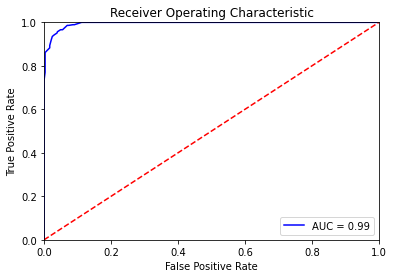

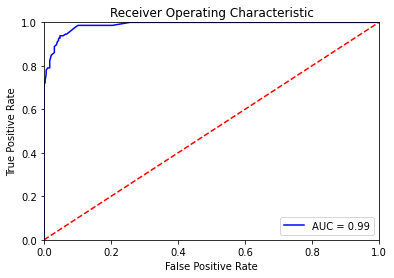

In [59]:
threshold_random_forest = plotAUROC(random_forest, X_test, y_test)
threshold_xgboost = plotAUROC(xgboost, X_test.to_numpy(), y_test.to_numpy())

In [69]:
def get_confusion_matrix(y_test, y_pred_test):
    pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_test),
                columns=['Predicted Not Poisonous', 'Predicted Poisonous'],
                index=['True Not Poisonous', 'True Poisonous']
                )